In [1]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

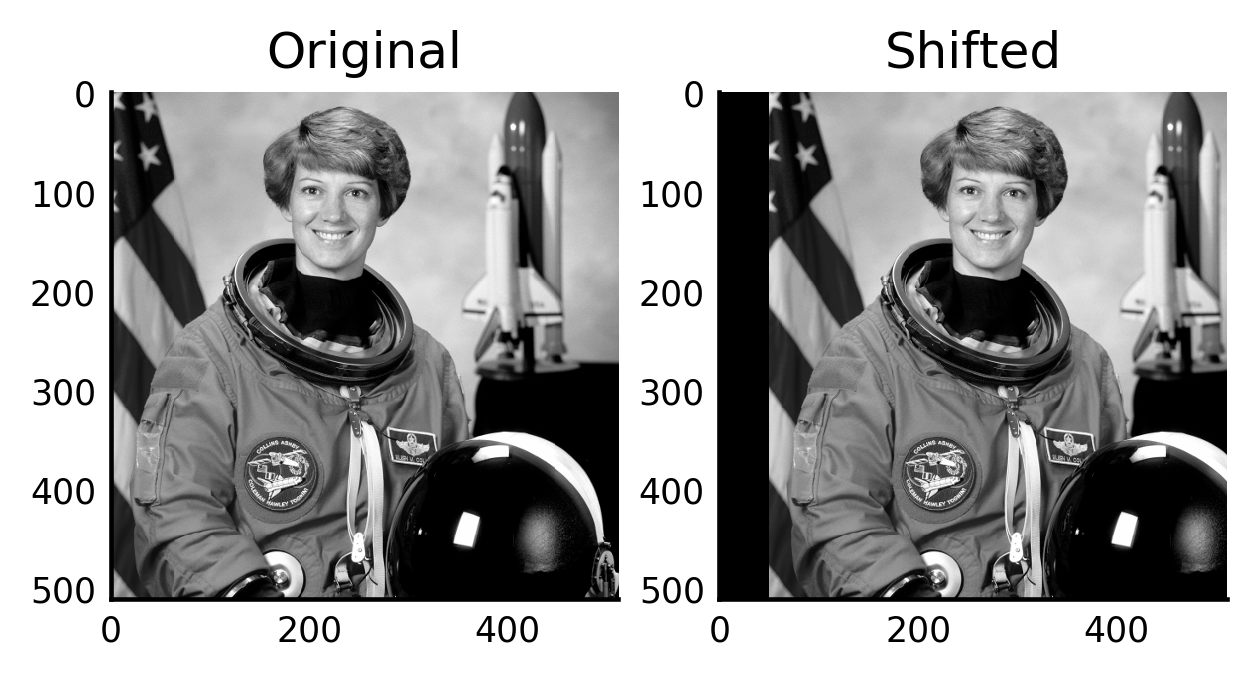

In [2]:
from skimage import data, color
from scipy import ndimage as ndi

astronaut = color.rgb2gray(data.astronaut())
shifted = ndi.shift(astronaut, (0, 50))

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(astronaut)
axes[0].set_title('Original')
axes[1].imshow(shifted)
axes[1].set_title('Shifted');

In [3]:
import numpy as np

def mse(arr1, arr2):
    """Compute the mean squared error between two arrays."""
    return np.mean((arr1 - arr2)**2)

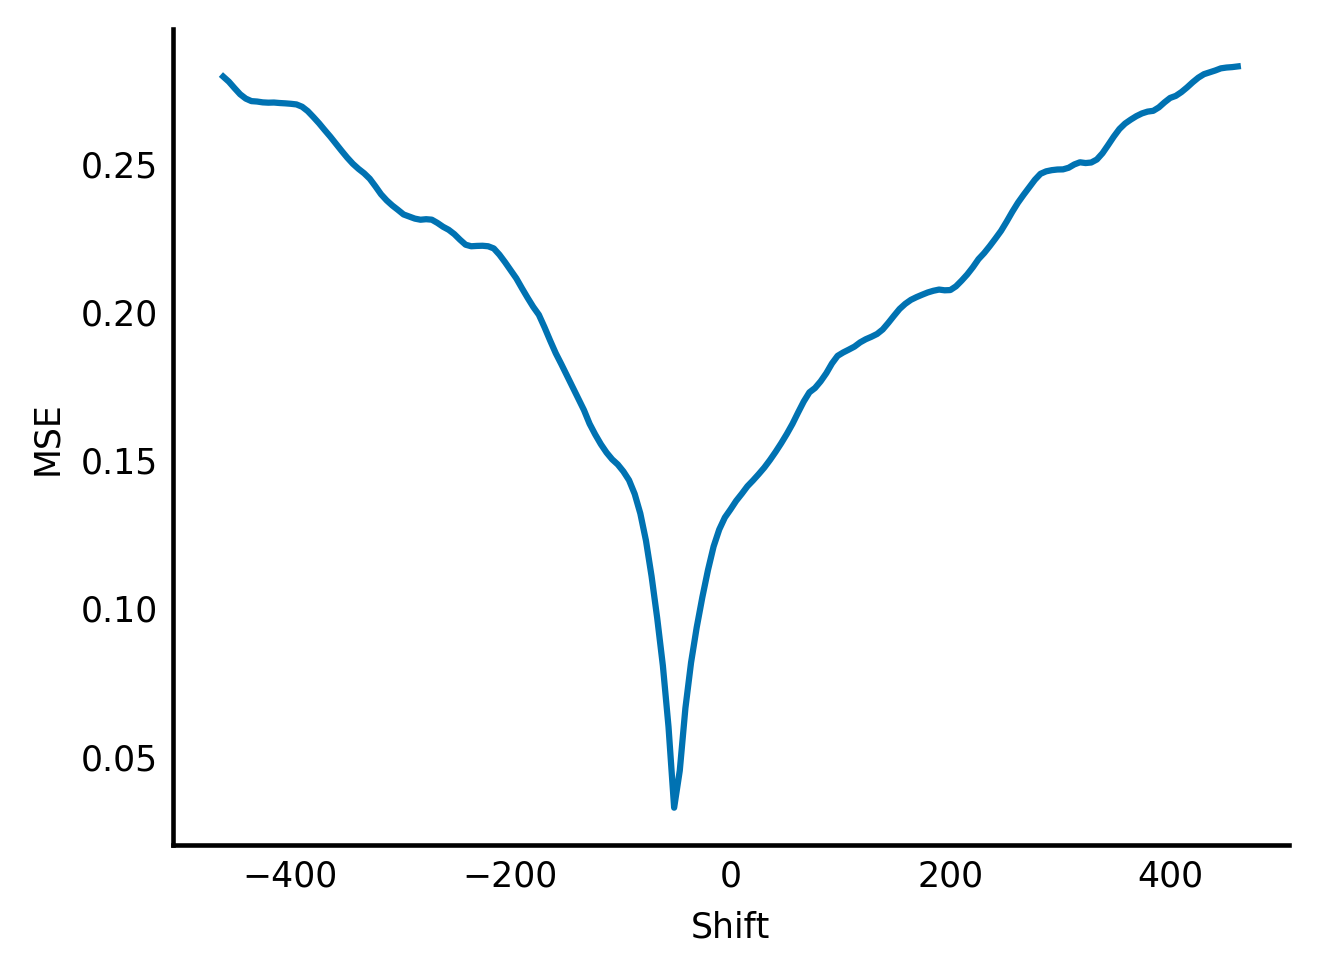

In [4]:
ncol = astronaut.shape[1]

# Cover a distance of 90% of the length in columns,
# with one value per percentage point
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
mse_costs = []

for shift in shifts:
    shifted_back = ndi.shift(shifted, (0, shift))
    mse_costs.append(mse(astronaut, shifted_back))

fig, ax = plt.subplots()
ax.plot(shifts, mse_costs)
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

In [5]:
from scipy import optimize

def astronaut_shift_error(shift, image):
    corrected = ndi.shift(image, (0, shift))
    return mse(astronaut, corrected)

res = optimize.minimize(astronaut_shift_error, 0, args=(shifted,),
                        method='Powell')

print(f'The optimal shift for correction is: {res.x}')

The optimal shift for correction is: -49.99997565757095


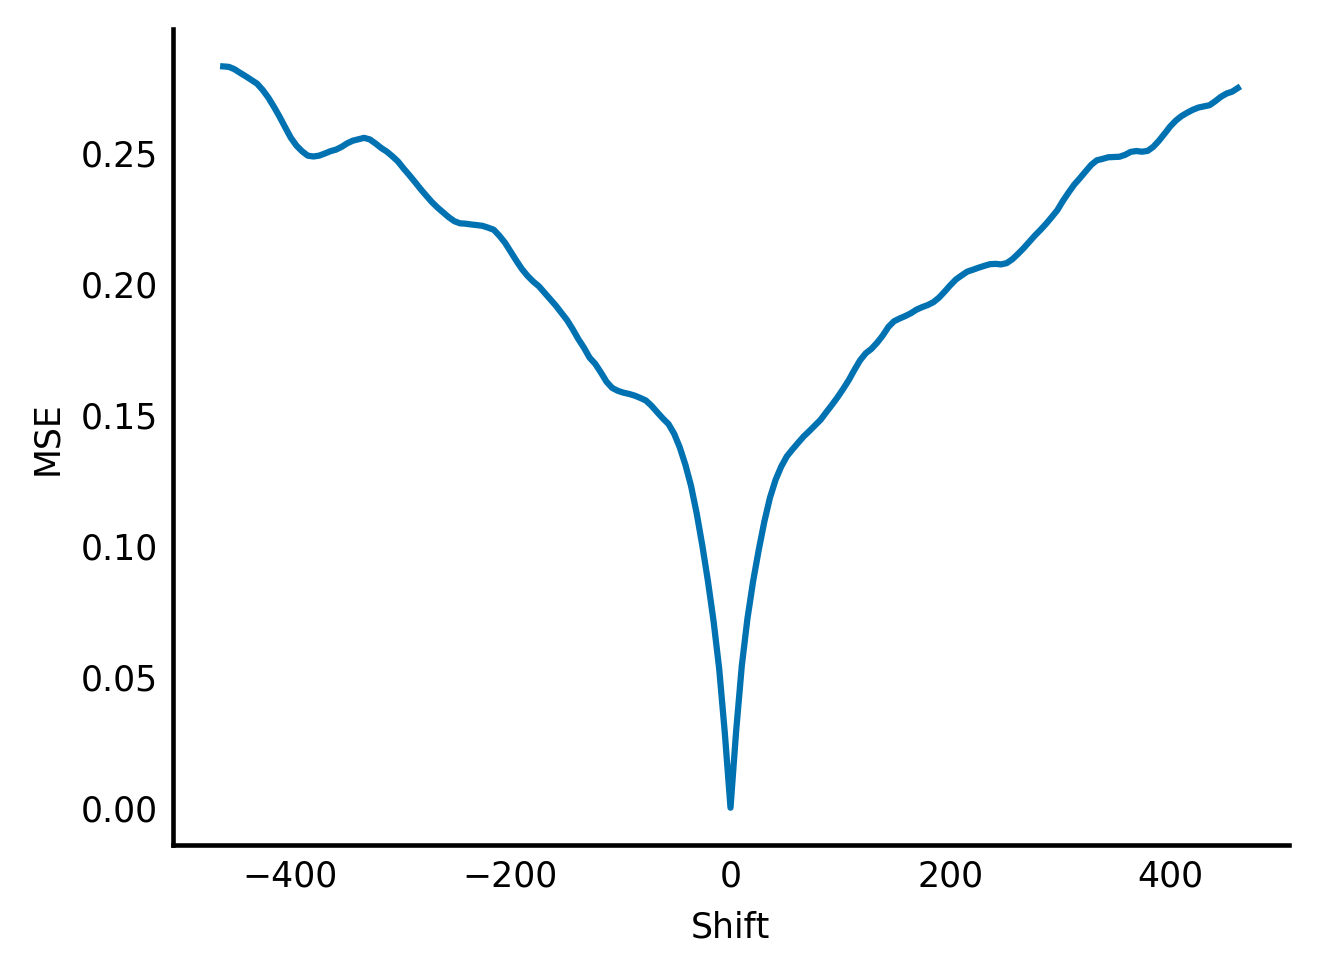

In [6]:
ncol = astronaut.shape[1]

# Cover a distance of 90% of the length in columns,
# with one value per percentage point
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
mse_costs = []

for shift in shifts:
    shifted1 = ndi.shift(astronaut, (0, shift))
    mse_costs.append(mse(astronaut, shifted1))

fig, ax = plt.subplots()
ax.plot(shifts, mse_costs)
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

In [7]:
shifted2 = ndi.shift(astronaut, (0, -340))

In [8]:
res = optimize.minimize(astronaut_shift_error, 0, args=(shifted2,),
                        method='Powell')

print(f'The optimal shift for correction is {res.x}')

The optimal shift for correction is -38.51778619396494


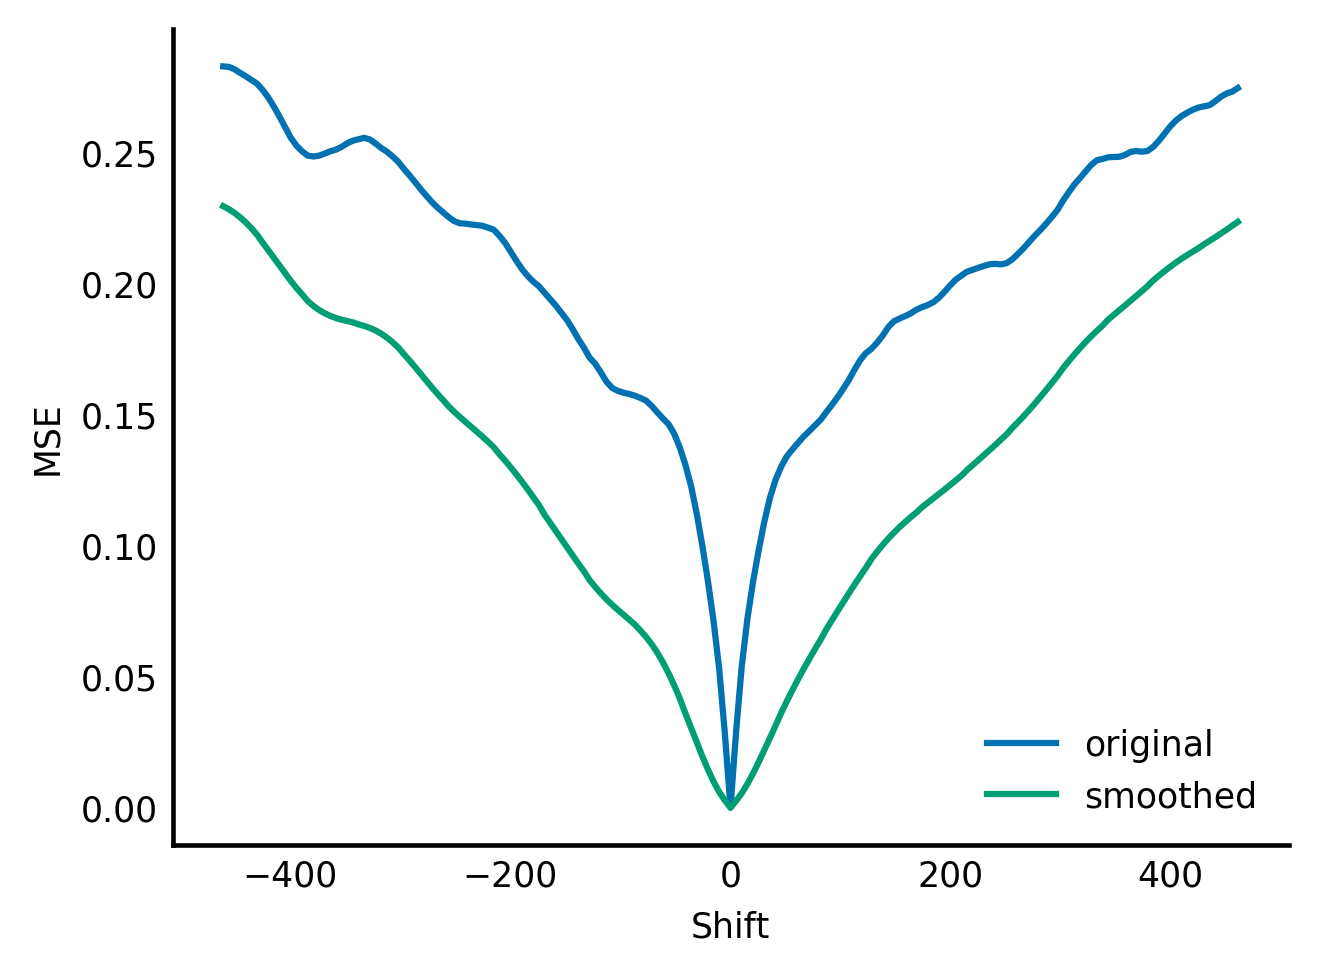

In [9]:
from skimage import filters

astronaut_smooth = filters.gaussian(astronaut, sigma=20)

mse_costs_smooth = []
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
for shift in shifts:
    shifted3 = ndi.shift(astronaut_smooth, (0, shift))
    mse_costs_smooth.append(mse(astronaut_smooth, shifted3))

fig, ax = plt.subplots()
ax.plot(shifts, mse_costs, label='original')
ax.plot(shifts, mse_costs_smooth, label='smoothed')
ax.legend(loc='lower right')
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

In [10]:
def downsample2x(image):
    offsets = [((s + 1) % 2) / 2 for s in image.shape]
    slices = [slice(offset, end, 2)
              for offset, end in zip(offsets, image.shape)]
    coords = np.mgrid[slices]
    return ndi.map_coordinates(image, coords, order=1)

In [11]:
def gaussian_pyramid(image, levels=6):
    """Make a Gaussian image pyramid.

    Parameters
    ----------
    image : array of float
        The input image.
    max_layer : int, optional
        The number of levels in the pyramid.

    Returns
    -------
    pyramid : iterator of array of float
        An iterator of Gaussian pyramid levels, starting with the top
        (lowest resolution) level.
    """
    pyramid = [image]

    for level in range(levels - 1):
        blurred = ndi.gaussian_filter(image, sigma=2/3)
        image = downsample2x(image)
        pyramid.append(image)

    return reversed(pyramid)

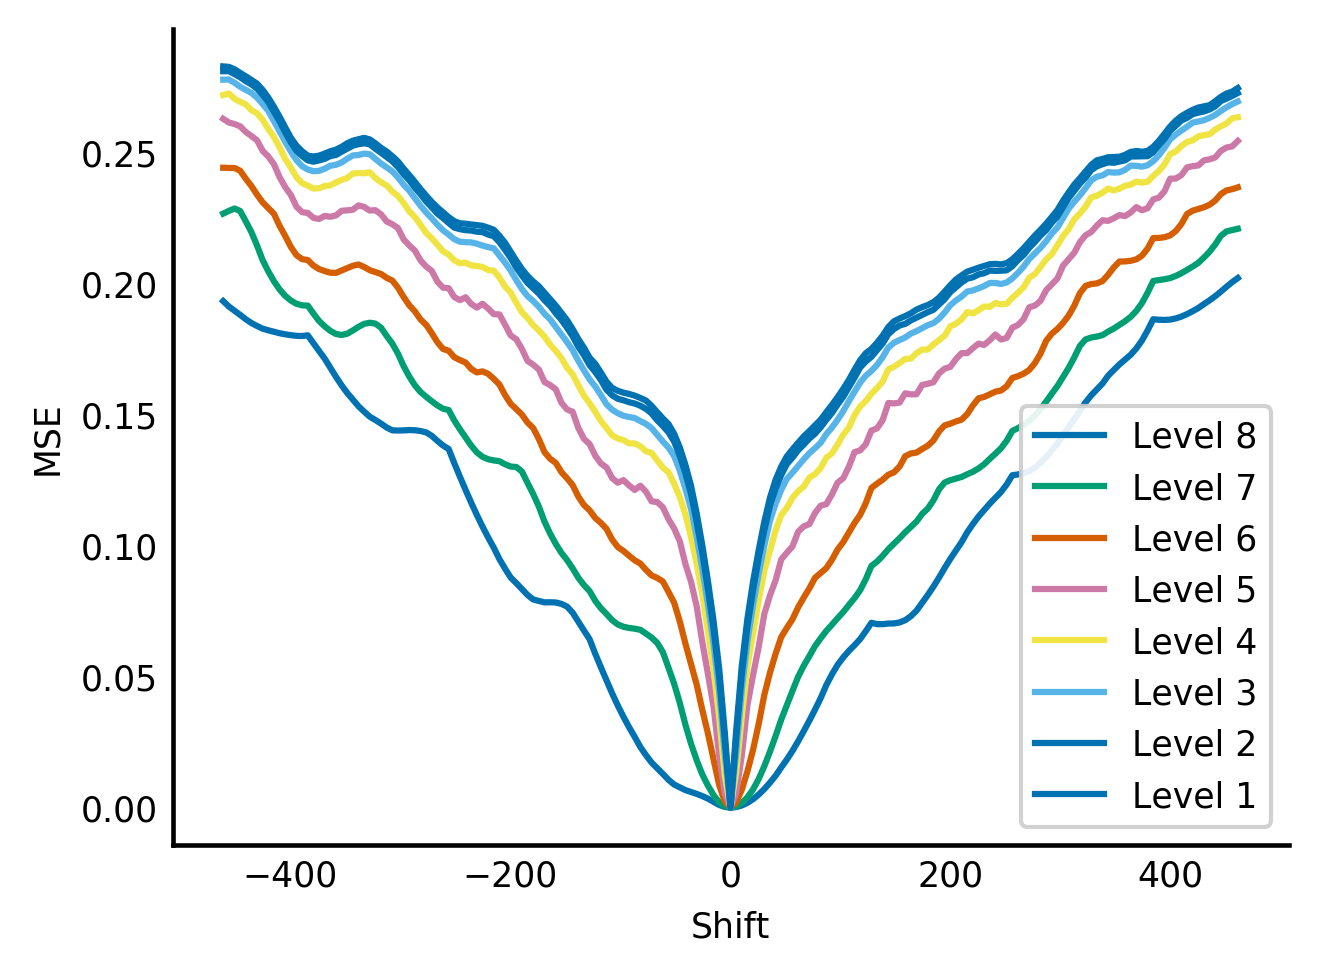

In [12]:
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
nlevels = 8
costs = np.empty((nlevels, len(shifts)), dtype=float)
astronaut_pyramid = list(gaussian_pyramid(astronaut, levels=nlevels))
for col, shift in enumerate(shifts):
    shifted = ndi.shift(astronaut, (0, shift))
    shifted_pyramid = gaussian_pyramid(shifted, levels=nlevels)
    for row, image in enumerate(shifted_pyramid):
        costs[row, col] = mse(astronaut_pyramid[row], image)

fig, ax = plt.subplots()
for level, cost in enumerate(costs):
    ax.plot(shifts, cost, label='Level %d' % (nlevels - level))
ax.legend(loc='lower right', frameon=True, framealpha=0.9)
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

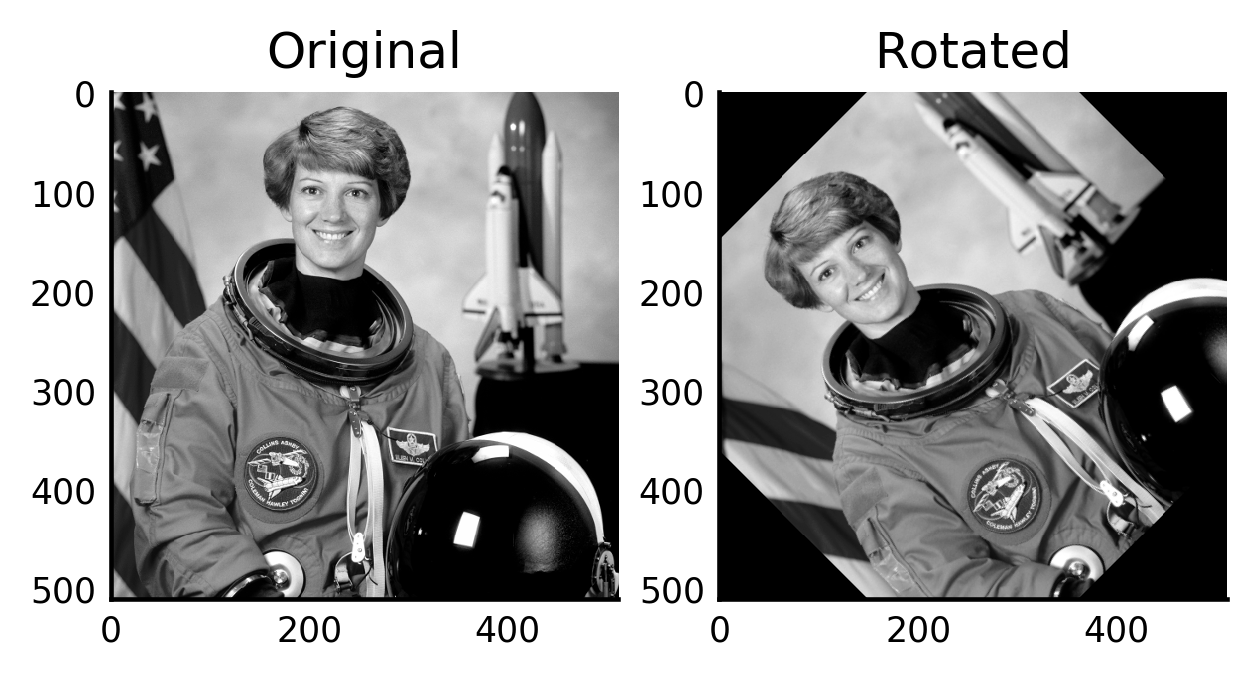

In [13]:
from skimage import transform

def make_rigid_transform(param):
    r, tc, tr = param
    return transform.SimilarityTransform(rotation=r,
                                         translation=(tc, tr))

rotated = transform.rotate(astronaut, 45)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(astronaut)
axes[0].set_title('Original')
axes[1].imshow(rotated)
axes[1].set_title('Rotated');

In [14]:
def cost_mse(param, reference_image, target_image):
    transformation = make_rigid_transform(param)
    transformed = transform.warp(target_image, transformation, order=3)
    return mse(reference_image, transformed)

In [15]:
def align(reference, target, cost=cost_mse):
    nlevels = 7
    pyramid_ref = gaussian_pyramid(reference, levels=nlevels)
    pyramid_tgt = gaussian_pyramid(target, levels=nlevels)

    levels = range(nlevels, 0, -1)
    image_pairs = zip(pyramid_ref, pyramid_tgt)

    p = np.zeros(3)

    for n, (ref, tgt) in zip(levels, image_pairs):
        p[1:] *= 2

        res = optimize.minimize(cost, p, args=(ref, tgt), method='Powell')
        p = res.x

        # print current level, overwriting each time (like a progress bar)
        print(f'Level: {n}, Angle: {np.rad2deg(res.x[0]) :.3}, '
              f'Offset: ({res.x[1] * 2**n :.3}, {res.x[2] * 2**n :.3}), '
              f'Cost: {res.fun :.3}', end='\r')

    print('')  # newline when alignment complete
    return make_rigid_transform(p)

Level: 1, Angle: -60.0, Offset: (-1.87e+02, 6.98e+02), Cost: 0.0369


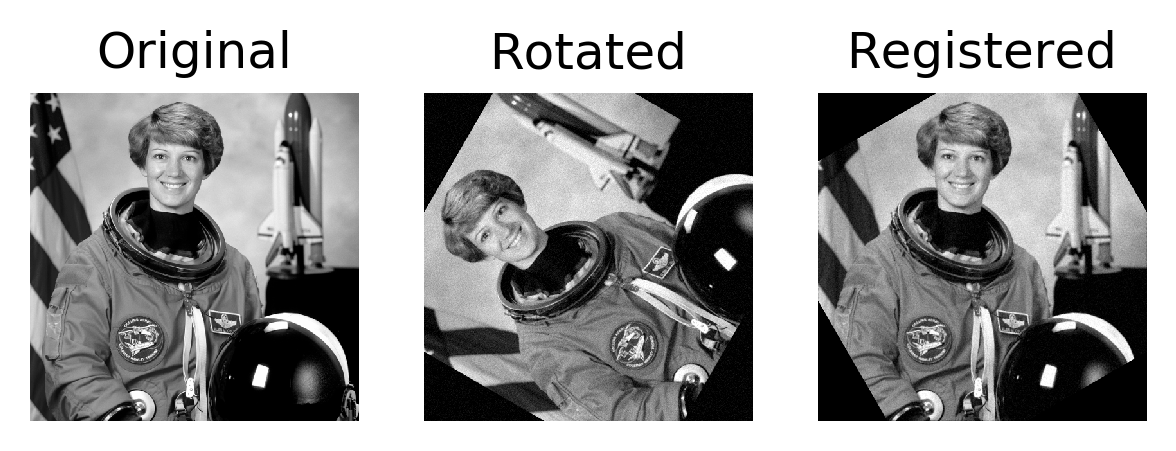

In [16]:
from skimage import util

theta = 60
rotated = transform.rotate(astronaut, theta)
rotated = util.random_noise(rotated, mode='gaussian',
                            seed=0, mean=0, var=1e-3)

tf = align(astronaut, rotated)
corrected = transform.warp(rotated, tf, order=3)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(astronaut)
ax0.set_title('Original')
ax1.imshow(rotated)
ax1.set_title('Rotated')
ax2.imshow(corrected)
ax2.set_title('Registered')
for ax in (ax0, ax1, ax2):
    ax.axis('off')

2Level: 1, Angle: 0.414, Offset: (2.85, 38.4), Cost: 0.141


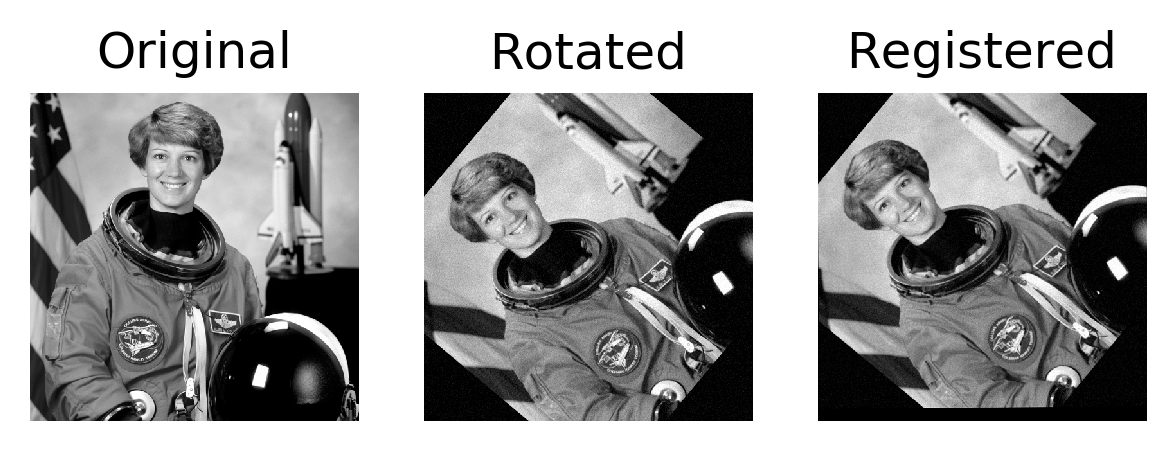

In [17]:
theta = 50
rotated = transform.rotate(astronaut, theta)
rotated = util.random_noise(rotated, mode='gaussian',
                            seed=0, mean=0, var=1e-3)

tf = align(astronaut, rotated)
corrected = transform.warp(rotated, tf, order=3)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(astronaut)
ax0.set_title('Original')
ax1.imshow(rotated)
ax1.set_title('Rotated')
ax2.imshow(corrected)
ax2.set_title('Registered')
for ax in (ax0, ax1, ax2):
    ax.axis('off')

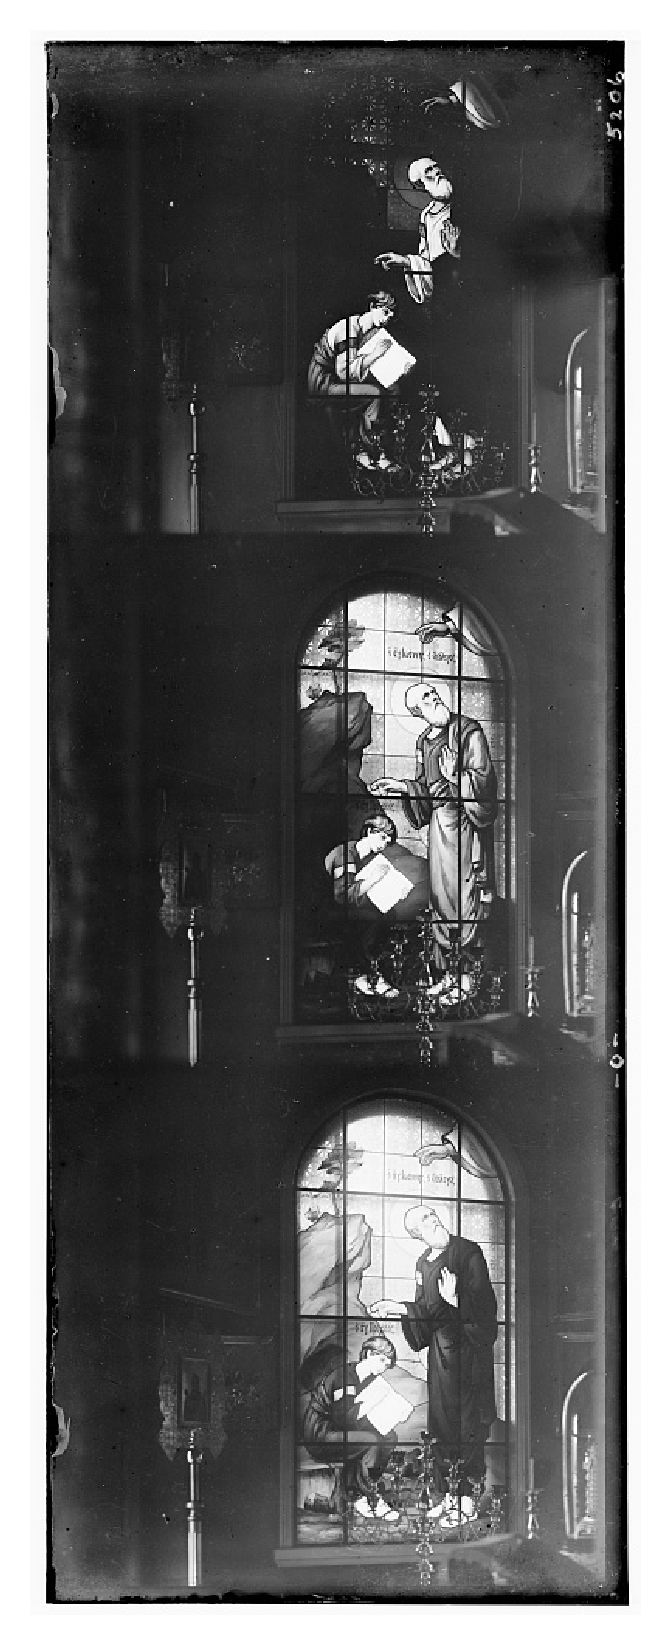

In [19]:
from skimage import io
stained_glass = io.imread('../data/00998v.jpg') / 255  # use float image in [0, 1]
fig, ax = plt.subplots(figsize=(4.8, 7))
ax.imshow(stained_glass)
ax.axis('off');

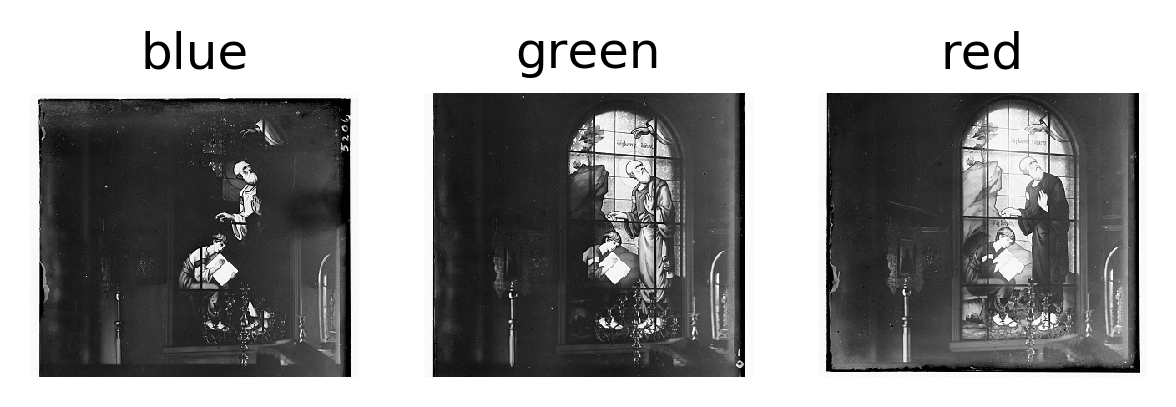

In [20]:
nrows = stained_glass.shape[0]
step = nrows // 3
channels = (stained_glass[:step],
            stained_glass[step:2*step],
            stained_glass[2*step:3*step])
channel_names = ['blue', 'green', 'red']
fig, axes = plt.subplots(1, 3)
for ax, image, name in zip(axes, channels, channel_names):
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(name)

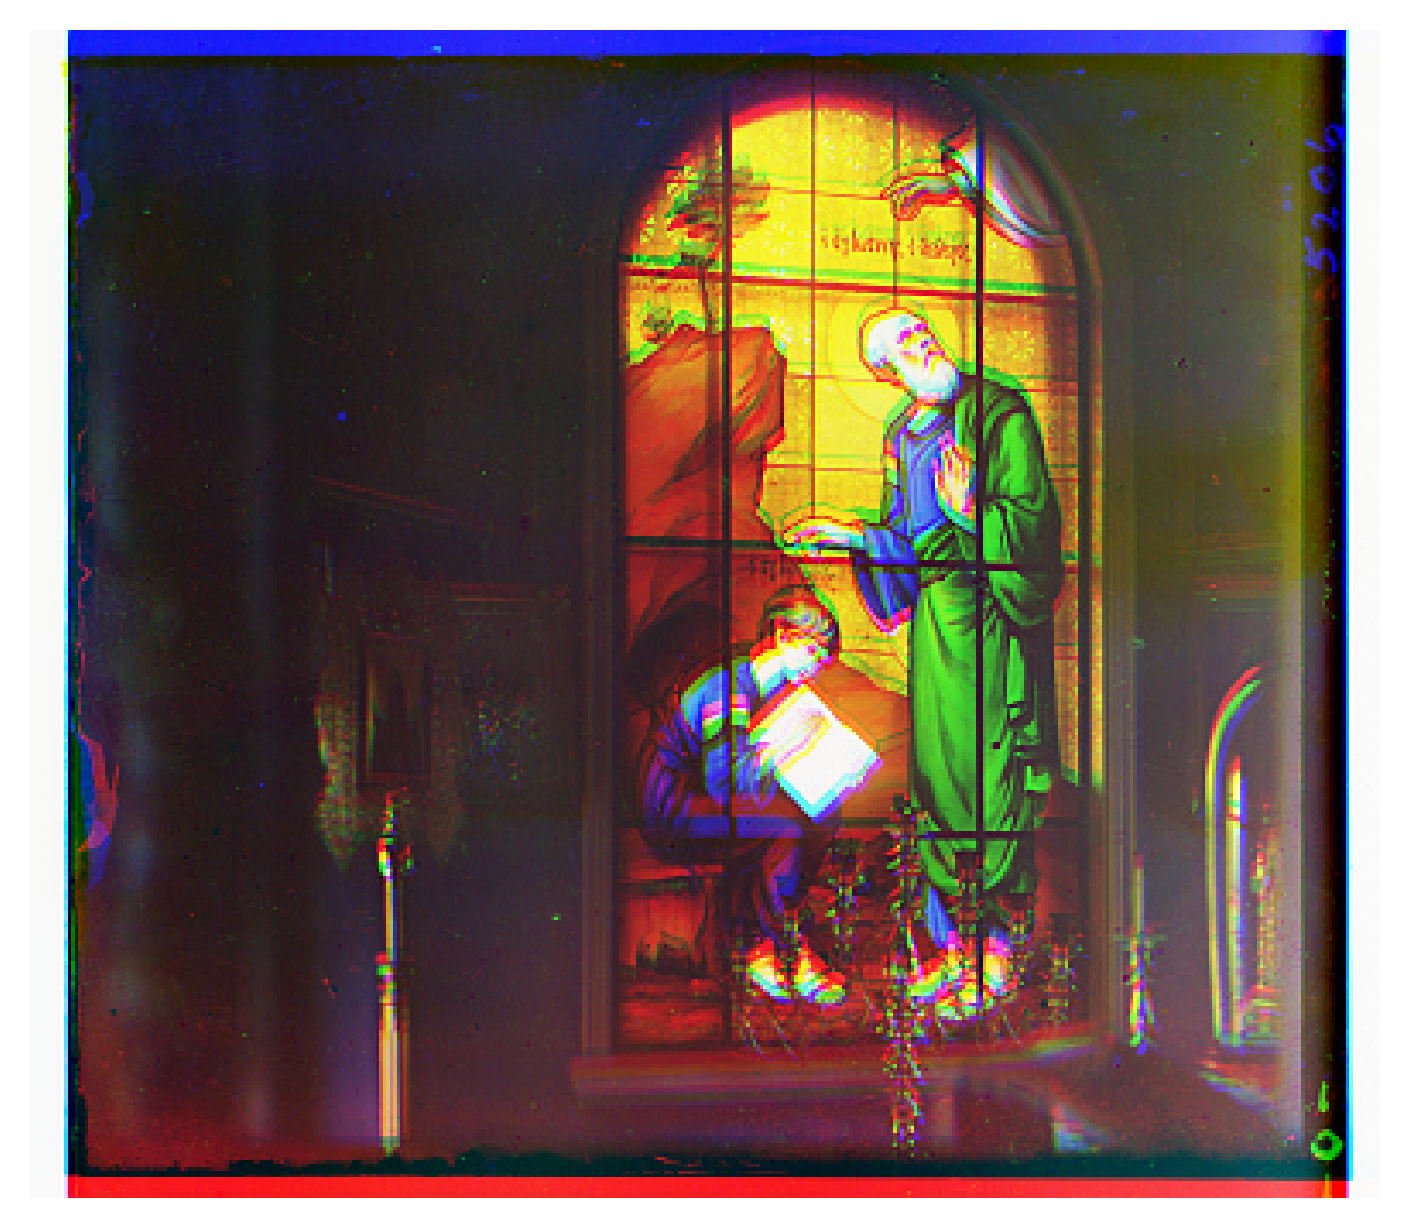

In [21]:
blue, green, red = channels
original = np.dstack((red, green, blue))
fig, ax = plt.subplots(figsize=(4.8, 4.8), tight_layout=True)
ax.imshow(original)
ax.axis('off');

*** Aligning blue to green ***
Level: 1, Angle: -0.0474, Offset: (-0.867, 15.4), Cost: 0.0499
** Aligning red to green ***
Level: 1, Angle: 0.0339, Offset: (-0.269, -8.88), Cost: 0.0311vel: 2, Angle: 0.0942, Offset: (0.353, -10.3), Cost: 0.028


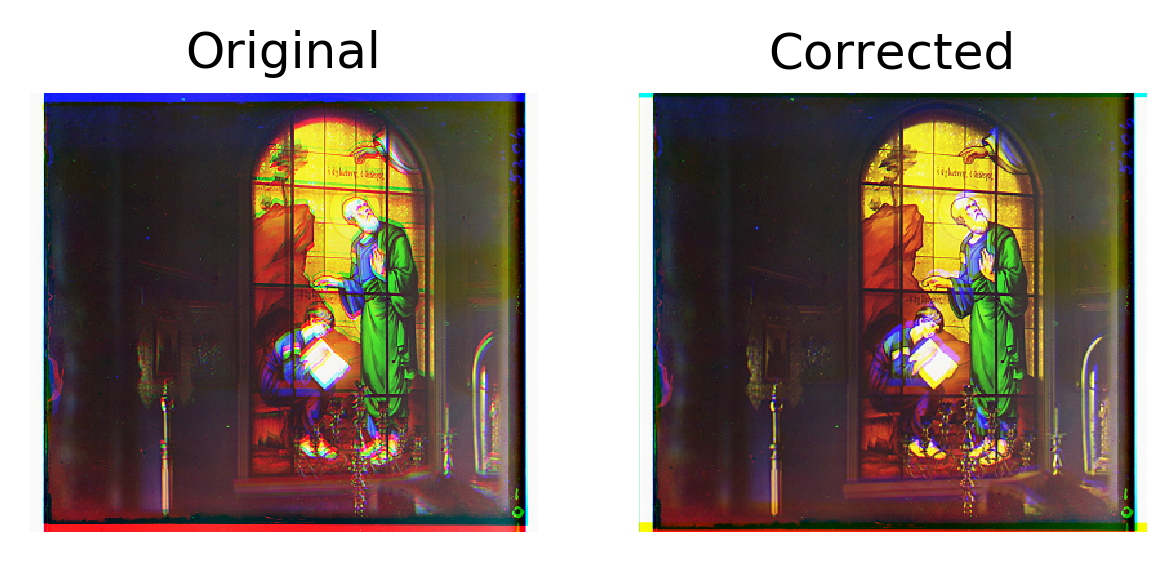

In [22]:
print('*** Aligning blue to green ***')
tf = align(green, blue)
cblue = transform.warp(blue, tf, order=3)

print('** Aligning red to green ***')
tf = align(green, red)
cred = transform.warp(red, tf, order=3)

corrected = np.dstack((cred, green, cblue))
f, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(original)
ax0.set_title('Original')
ax1.imshow(corrected)
ax1.set_title('Corrected')
for ax in (ax0, ax1):
    ax.axis('off')

In [23]:
from scipy.stats import entropy

def normalized_mutual_information(A, B):
    """Compute the normalized mutual information.

    The normalized mutual information is given by:

                H(A) + H(B)
      Y(A, B) = -----------
                  H(A, B)

    where H(X) is the entropy ``- sum(x log x) for x in X``.

    Parameters
    ----------
    A, B : ndarray
        Images to be registered.

    Returns
    -------
    nmi : float
        The normalized mutual information between the two arrays, computed at a
        granularity of 100 bins per axis (10,000 bins total).
    """
    hist, bin_edges = np.histogramdd([np.ravel(A), np.ravel(B)], bins=100)
    hist /= np.sum(hist)

    H_A = entropy(np.sum(hist, axis=0))
    H_B = entropy(np.sum(hist, axis=1))
    H_AB = entropy(np.ravel(hist))

    return (H_A + H_B) / H_AB

In [24]:
def cost_nmi(param, reference_image, target_image):
    transformation = make_rigid_transform(param)
    transformed = transform.warp(target_image, transformation, order=3)
    return -normalized_mutual_information(reference_image, transformed)

*** Aligning blue to green ***
7Level: 5, Angle: 2.48, Offset: (23.9, -0.0692), Cost: -1.34Level: 3, Angle: 0.725, Offset: (6.5, 1.24), Cost: -1.12Level: 1, Angle: 0.444, Offset: (6.07, 0.354), Cost: -1.08
** Aligning red to green ***
: 3, Angle: -0.899, Offset: (-5.8, -0.448), Cost: -1.14Level: 1, Angle: 0.000657, Offset: (-0.635, -7.67), Cost: -1.11


(-0.5, 393.5, 340.5, -0.5)

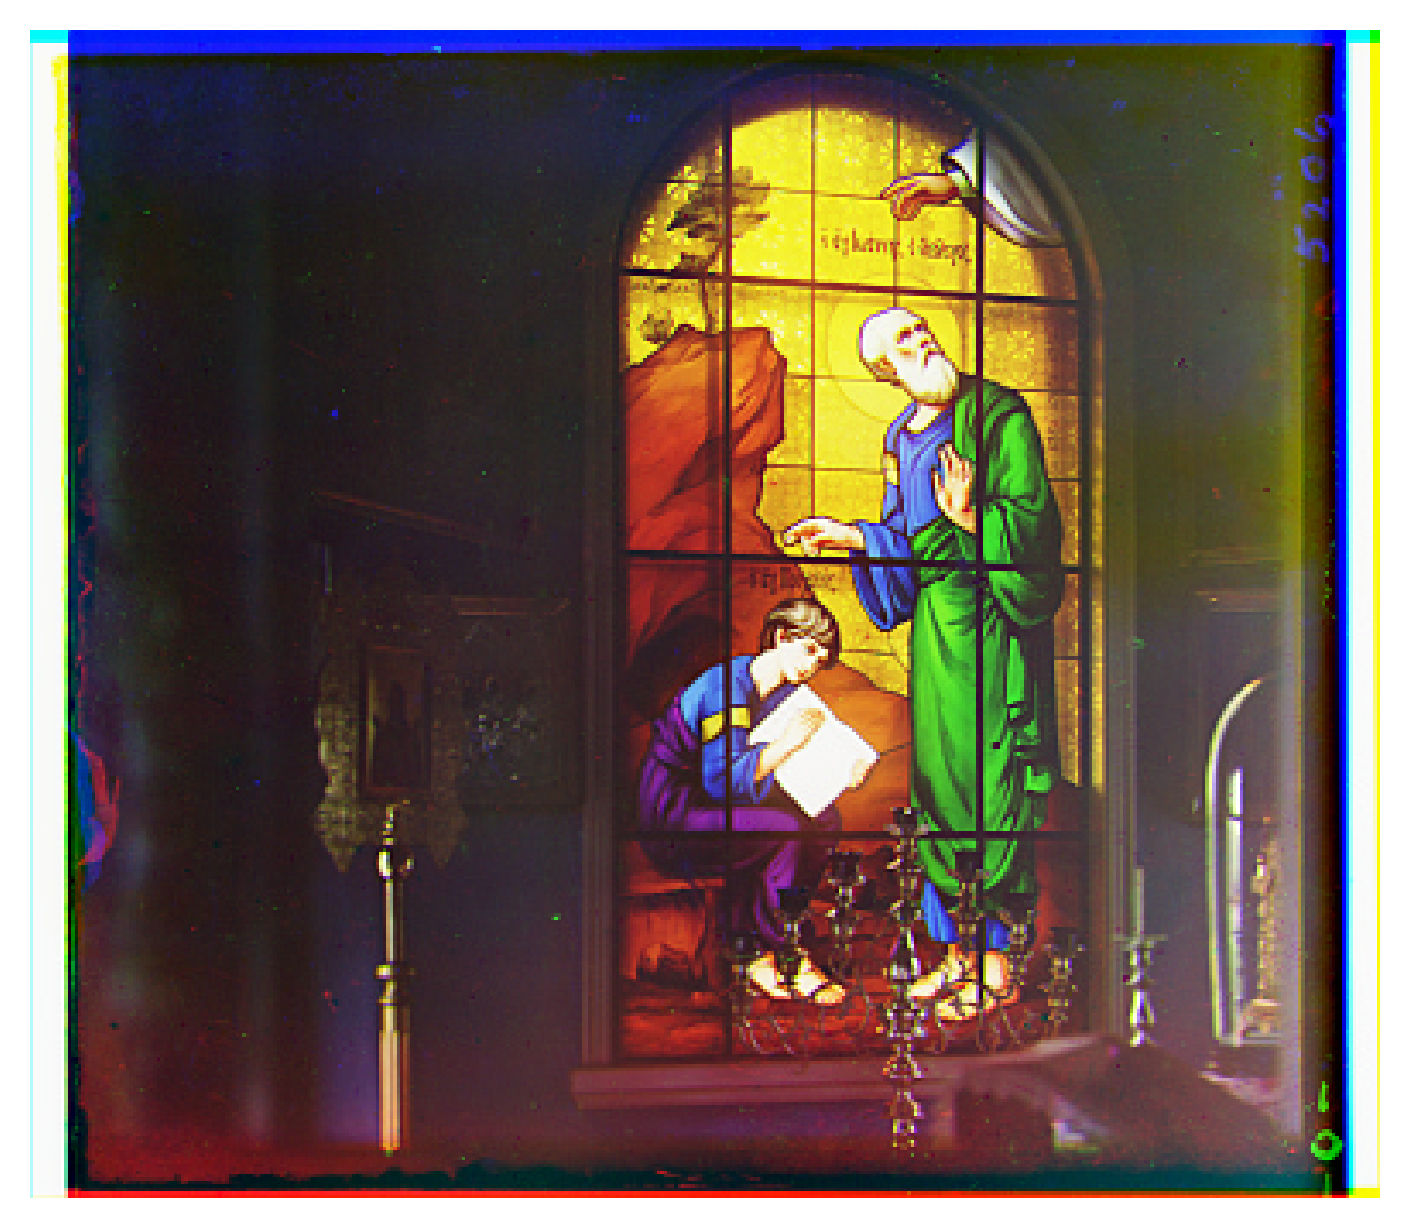

In [25]:
print('*** Aligning blue to green ***')
tf = align(green, blue, cost=cost_nmi)
cblue = transform.warp(blue, tf, order=3)

print('** Aligning red to green ***')
tf = align(green, red, cost=cost_nmi)
cred = transform.warp(red, tf, order=3)

corrected = np.dstack((cred, green, cblue))
fig, ax = plt.subplots(figsize=(4.8, 4.8), tight_layout=True)
ax.imshow(corrected)
ax.axis('off')